# Metrics analysis - Worker failure
This notebook visualizes worker failures.

In [1]:
NOTEBOOK_PHASE = 3

if (NOTEBOOK_PHASE == 1):
    inputfactor = 1
elif(NOTEBOOK_PHASE == 2):
    inputfactor = 2
elif(NOTEBOOK_PHASE == 3):
    inputfactor = 3.166667    

print("Will use input factor: " + str(inputfactor))

Will use input factor: 3.166667


In [2]:
# settings for saving plots
saveplots = True
dpiResolution = 200

In [3]:
import pyspark.sql.functions as F
import numpy as np
# Import to indent the plots in the notebook
%matplotlib notebook
%matplotlib inline
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.collections as collections
import seaborn as sns
from IPython.core.display import display, HTML
from PIL import Image
from matplotlib.lines import Line2D
from matplotlib.ticker import AutoMinorLocator

In [4]:
# Python imports
import pandas as pd 
from collections import defaultdict
from datetime import timedelta
from datetime import datetime
import numpy as np
import pytz
import math

# SQL imports
from pyspark.sql.functions import isnan, when, count, col, lead, udf, lag, to_date, avg, desc, sum, min
from pyspark.sql import Window
from pyspark.sql import functions
from pyspark.sql.types import IntegerType, LongType, DoubleType, TimestampType, StringType

In [5]:
# settings to get plots in the right style
plt.style.use('ggplot')
plt.style.use('seaborn-deep')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'lightgrey'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.titleweight'] = 'normal'
plt.rcParams['figure.edgecolor'] = 'lightgrey'
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['legend.edgecolor'] = 'lightgrey'
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['figure.titleweight'] ='bold'
plt.rcParams['grid.color'] = 'grey'
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] ='out'
plt.rcParams["date.autoformatter.minute"] = "%H:%M"
plt.rcParams["font.family"] = "Times New Roman"

In [6]:
# check if Spark is running
spark

In [7]:
# List of which frameworks should be included in this comparison
frameworks_that_could_be_in_the_data = ["FLINK", "KAFKASTREAMS", "SPARK", "STRUCTUREDSTREAMING"]
frameworksPrintable = {
    "SPARK": "Spark Streaming", 
    "STRUCTUREDSTREAMING":"Structured Streaming", 
    "FLINK": "Flink", 
    "KAFKASTREAMS": "Kafka Streams"   
}
stages=["ingest", "parse", "join", "aggregate", "window"]

In [8]:
dataPath = dict()
for i in frameworks_that_could_be_in_the_data:
    dataPath[i + "_ALO"] = "./scalability-data/worker-failure/" + i + "/stage" + str(NOTEBOOK_PHASE) + "/5x-4cpu-20gb/atleastonce/*"
    if((i=="FLINK") | (i=="KAFKASTREAMS")):
        dataPath[i + "_EO"] = "./scalability-data/worker-failure/" + i + "/stage" + str(NOTEBOOK_PHASE) + "/5x-4cpu-20gb/exactlyonce/*"
 

In [9]:
print("The paths that will be read: ")
dataPath

The paths that will be read: 


{'FLINK_ALO': './scalability-data/worker-failure/FLINK/stage3/5x-4cpu-20gb/atleastonce/*',
 'FLINK_EO': './scalability-data/worker-failure/FLINK/stage3/5x-4cpu-20gb/exactlyonce/*',
 'KAFKASTREAMS_ALO': './scalability-data/worker-failure/KAFKASTREAMS/stage3/5x-4cpu-20gb/atleastonce/*',
 'KAFKASTREAMS_EO': './scalability-data/worker-failure/KAFKASTREAMS/stage3/5x-4cpu-20gb/exactlyonce/*',
 'SPARK_ALO': './scalability-data/worker-failure/SPARK/stage3/5x-4cpu-20gb/atleastonce/*',
 'STRUCTUREDSTREAMING_ALO': './scalability-data/worker-failure/STRUCTUREDSTREAMING/stage3/5x-4cpu-20gb/atleastonce/*'}

## General Methods

For printing the quantiles of a column:
provide a list of quantiles

In [10]:
def datetimeFromEpoch(epoch):
    return datetime.utcfromtimestamp(epoch//1000).replace(microsecond=epoch%1000*1000)

datetimeFromEpochUDF = functions.udf(datetimeFromEpoch, TimestampType())

In [11]:
def save_img_colored_and_grayscale(path_colored_img):
    if saveplots: 
        plt.savefig(path_colored_img + '.png', dpi=dpiResolution, bbox_inches="tight", pad_inches = 0)
        im = Image.open(path_colored_img + '.png').convert('L')
        im.save(path_colored_img + '_grayscale.png', dpi=(300, 300))

# Latency 
Read in latency data and transform in the right format for plotting.

In [12]:
# Check if each framework had all containers running during the benchmark. To avoid including runs which had issues with some components. 
frameworks = []
containerCheck = defaultdict(dict)
for framework in frameworks_that_could_be_in_the_data:
    for proc_semantic in ["_ALO", "_EO"]:
        try:
            if framework == "KAFKASTREAMS":
                requiredAmtContainers = 5 
            elif framework == "FLINK": 
                requiredAmtContainers = 6
            else:
                requiredAmtContainers = 7
                
            containerCheckPhase = spark.read.option("header", "true").option("inferSchema", "true") \
            .csv(dataPath[framework + proc_semantic] + "/cpu-per-container-timeseries.csv/*")
            amtOfContainers = containerCheckPhase.select("containerName").distinct().count()
            if amtOfContainers != requiredAmtContainers:
                containerCheckPhase.select("containerName").distinct().show()
                print("WARNING FOR " + framework + " volume: " + str(NOTEBOOK_PHASE) + " amount of containers: " + str(amtOfContainers))
            else:
                frameworks.append(framework + proc_semantic)
                print("all checks passed for " + framework + proc_semantic)
        except:
            print('framework ' + framework + proc_semantic + " not in data")

all checks passed for FLINK_ALO
all checks passed for FLINK_EO
all checks passed for KAFKASTREAMS_ALO
all checks passed for KAFKASTREAMS_EO
all checks passed for SPARK_ALO
framework SPARK_EO not in data
all checks passed for STRUCTUREDSTREAMING_ALO
framework STRUCTUREDSTREAMING_EO not in data


In [13]:
latencyTimeseriesDataWithoutStartup = dict()
minTimeSec = dict()
for framework in frameworks:
    print(framework)
    latencyTimeseriesDataPhase = spark.read.option("header", "true").option("inferSchema", "true") \
        .csv(dataPath[framework] + "/latency-timeseries-data-without-startup.csv/*") \
        .withColumn("time", datetimeFromEpochUDF(col("outputBucketTime")))

    minTimeInDF = latencyTimeseriesDataPhase.select("startTime").agg(min("startTime")).collect()[0][0]
    if ((framework == "SPARK_EO") | (framework == "STRUCTUREDSTREAMING_EO") | (framework == "SPARK_ALO") | (framework == "STRUCTUREDSTREAMING_ALO")):
        minTimeSec[framework] = (int(minTimeInDF)) / 60000
    else:
        minTimeSec[framework] =  int(minTimeInDF) / 60000
    
    latencyTimeseriesDataWithoutStartup[framework] = latencyTimeseriesDataPhase.withColumn("timeSec", (col("outputBucketTime")/60000.0)-minTimeSec[framework])


FLINK_ALO
FLINK_EO
KAFKASTREAMS_ALO
KAFKASTREAMS_EO
SPARK_ALO
STRUCTUREDSTREAMING_ALO


# Throughput

## Stage 0 throughput

In [14]:
throughputTimeseriesDataWithStartup = dict()
for framework in frameworks:
    throughputTimeseriesDataWithStartupPhase = spark.read.option("header", "true").option("inferSchema", "true") \
        .csv(dataPath[framework] + "/output-throughput-timeseries-second-buckets.csv/*") \
        .withColumn("time", datetimeFromEpochUDF(col("outputBucketTime")))    

    throughputTimeseriesDataWithStartup[framework] = throughputTimeseriesDataWithStartupPhase.withColumn("timeSec", (col("outputBucketTime")/60000.0)-minTimeSec[framework])

inputThroughputTimeseriesDataWithStartup = dict()
for framework in frameworks:
    inputThroughputTimeseriesDataWithStartupPhase = spark.read.option("header", "true").option("inferSchema", "true") \
        .csv(dataPath[framework] + "/input-throughput-timeseries-second-buckets.csv/*") \
        .withColumn("time", datetimeFromEpochUDF(col("inputBucketTime")))    

    inputThroughputTimeseriesDataWithStartup[framework] = inputThroughputTimeseriesDataWithStartupPhase.withColumn("timeSec", (col("inputBucketTime")/60000.0)-minTimeSec[framework])


# CPU 

In [15]:
cpuTimeseries = dict()
for framework in frameworks:
    try:
        cpuTimeseries[framework] = spark.read.option("header", "true").option("inferSchema", "true") \
            .csv(dataPath[framework] + "/cpu-per-container-timeseries.csv/*") \
            .withColumn("timeParsed", datetimeFromEpochUDF(col("time")))
        
        
        
    except:
        print("didnt work for " + framework)

In [16]:
containersPandas = dict()
for framework in frameworks:
    containersPandas[framework] = cpuTimeseries[framework].select("containerName").distinct().toPandas()

In [17]:
# You can use this to assign different colors to the different workers in the plot. We didn't use this here.
# Map label to RGB
color_map = dict()
for framework in frameworks:
    #Assign different color to each container
    rgb_values = sns.diverging_palette(255, 133, l=60, n=len(containersPandas[framework]), center="dark")
    color_map[framework] = dict(zip(containersPandas[framework]['containerName'], rgb_values))

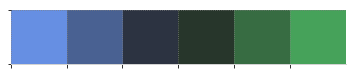

In [18]:
sns.palplot(sns.diverging_palette(255, 133, l=60, n=len(containersPandas), center="dark"))

In [19]:
# Map label to RGB
color_map = defaultdict(dict)
for framework in frameworks:
    #Assign different color to each container:
    rgb_values = sns.husl_palette(len(containersPandas[framework]), h=0.4, l=0.65, s=1) 
    color_map[framework] = dict(zip(containersPandas[framework]['containerName'], rgb_values))

## CPU timeseries analysis

In [20]:
cpuTimeseriesDataWithStartup = dict()
for framework in frameworks:
    cpuOfPhasePerContainer = spark.read.option("header", "true").option("inferSchema", "true") \
        .csv(dataPath[framework] + "/cpu-per-container-timeseries.csv/*") \
        .withColumn("timeParsed", datetimeFromEpochUDF(col("time")))

    cpuTimeseriesDataWithStartup[framework] = cpuOfPhasePerContainer \
        .withColumn("timeSec", (col("time")/60000.0)-minTimeSec[framework])

In [21]:
containersPandasPerPhase = dict()
for framework in frameworks:
    containersPandasPerPhase[framework] = cpuTimeseriesDataWithStartup[framework] \
        .select("containerName").distinct().orderBy("containerName").toPandas()

# Metric correlations
Plotting different metrics for a certain stage together.

For generating a chart of the four metrics

In [22]:
stageLatencyPandasShortSample = dict()
stageThroughputPandasShortSample = dict()
stageInputThroughputPandasShortSample = dict()
stageCpuPandasShortSample = dict()
start = 8.5
end = 10.5
for j, framework in enumerate(frameworks):
    print(framework)
    stageLatencyPandasShortSample[framework] = latencyTimeseriesDataWithoutStartup[framework].orderBy("timeSec") \
        .filter((col("timeSec") >start) & (col("timeSec")<end)).toPandas()
    stageThroughputPandasShortSample[framework] = throughputTimeseriesDataWithStartup[framework].orderBy("timeSec") \
        .filter((col("timeSec") >start) & (col("timeSec")<end)).toPandas()
    stageInputThroughputPandasShortSample[framework] = inputThroughputTimeseriesDataWithStartup[framework].orderBy("timeSec") \
        .filter((col("timeSec") >start) & (col("timeSec")<end)).toPandas()
    stageCpuPandasShortSample[framework] = cpuTimeseriesDataWithStartup[framework].orderBy("timeSec")\
        .filter((col("timeSec") >start) & (col("timeSec")<end)).toPandas()

FLINK_ALO
FLINK_EO
KAFKASTREAMS_ALO
KAFKASTREAMS_EO
SPARK_ALO
STRUCTUREDSTREAMING_ALO


In [23]:
def generateWorkerFailureChart(colNum, containersPandas, latencyPandas, throughputPandas, inputThroughputPandas, cpuPandas, start, end):
    minor_x_locator = AutoMinorLocator(5) # how many minor grid lines in between two major grid lines for x axis
      
    # we entered this manually based on the excel and manual computation
    recovery_time = {
        "FLINK_EO": 58,
        "KAFKASTREAMS_EO": 32,
        "SPARK_EO": 23,
        "STRUCTUREDSTREAMING_EO": 22,
        "FLINK_ALO": 53,
        "KAFKASTREAMS_ALO": 21,
        "SPARK_ALO": 30,
        "STRUCTUREDSTREAMING_ALO": 20
    }
    pct50_line, = ax[0, colNum].plot(latencyPandas["timeSec"], latencyPandas["percentile_50_second"], color="#606060", linestyle="solid", label = "50p")
    pct99_line, = ax[0, colNum].plot(latencyPandas["timeSec"], latencyPandas["percentile_99_second"], color="black", linestyle="solid", label = "99p")
    ax[0, colNum].set_ylim(ymin=0, ymax=20000)
    ax[0, colNum].set_xlim(xmin=start, xmax=end)
    ax[0, colNum].xaxis.set_minor_locator(minor_x_locator)
    minor_y_locator_1 = AutoMinorLocator(2) # how many minor grid lines in between two major grid lines for y axis
    ax[0, colNum].yaxis.set_minor_locator(minor_y_locator_1)
    ax[0, colNum].grid(which='minor', color='black')
    ax[0, colNum].get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x/1000.0), ',').replace(',', ' ') + " s"))
    
    tp_line1 = ax[1, colNum].scatter(throughputPandas["timeSec"], throughputPandas["outputMsgCount"], zorder = 10, s = 3, label = "output", color="#151515")
    tp_line2, = ax[1, colNum].plot(inputThroughputPandas["timeSec"], inputThroughputPandas["inputMsgCount"].multiply(inputfactor), zorder = 10, label = "input", color="black", linestyle = "--")
    ax[1, colNum].get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x/1000.0), ',').replace(',', ' ')))
    ax[1, colNum].set_ylim(ymin=0, ymax=40000)
    minor_y_locator_2 = AutoMinorLocator(2) # how many minor grid lines in between two major grid lines for y axis
    ax[1, colNum].yaxis.set_minor_locator(minor_y_locator_2)
    ax[1, colNum].xaxis.set_minor_locator(minor_x_locator)
    ax[1, colNum].set_yticks([0, 20000, 40000])
    ax[1, colNum].grid(which='minor', color='black')
    
    for contNum, containerId in enumerate(containersPandasPerPhase[framework]['containerName']):
        data = cpuPandas.loc[cpuPandas['containerName'] == containerId]
        if "-1" in containerId:
            # to know when the failure happened we look at the maximum timestamp of the first container
            first_container_id = data[data['timeSec'] == data['timeSec'].min()]["containerTaskId"].iloc[0]
            time_of_failure = cpuPandas.loc[cpuPandas['containerTaskId'] == first_container_id]["timeSec"].max()
            # to know when the new container came up, we look at the minimum timestamp of the second container
            restarted_container_id = data[data['timeSec'] == data['timeSec'].max()]["containerTaskId"].iloc[0]
            time_restart_finished = cpuPandas.loc[cpuPandas['containerTaskId'] == restarted_container_id]["timeSec"].min()
            
            print("time of failure at for " + framework + " " + str(time_of_failure*60) + " time of restart at " + str(time_restart_finished*60))
            print("total outage duration for " + framework + " " + str((time_restart_finished*60-time_of_failure*60)))
            
            for rowNum in [0, 1, 2]:
                ax[rowNum, colNum].axvspan(time_of_failure, time_of_failure + recovery_time[framework]/60, facecolor='#C0C0C0', alpha=0.5)
            cpu_worker_line_1 = ax[2, colNum].scatter(data['timeSec'], data['cpuUsagePct'], 
               c="black", label="cpu usage worker", s = 2, zorder = 20)
        else:
            cpu_worker_line_others = ax[2, colNum].scatter(data['timeSec'], data['cpuUsagePct'], 
               c="grey", label="cpu usage worker", s = 2, zorder = 10)


    ax[2, colNum].set_ylim(ymin=0, ymax=110)
    ax[2, colNum].set_yticks([0, 50, 100])
    ax[2, colNum].xaxis.set_minor_locator(minor_x_locator)
    minor_y_locator_3 = AutoMinorLocator(2) # how many minor grid lines in between two major grid lines for y axis
    ax[2, colNum].yaxis.set_minor_locator(minor_y_locator_3)
    ax[2, colNum].grid(which='minor', color='black')
    ax[2, colNum].get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: str(int(x)) + "%"))
    ax[2, colNum].set_xlabel("minute")

    if (colNum == 0):
        ax[0, colNum].set_ylabel("latency")
        ax[1, colNum].set_ylabel("throughput\nx1000 msg/s")
        ax[2, colNum].set_ylabel("CPU")
    
    if (colNum == len(frameworks)-1):
        ax[0, colNum].legend(loc = "upper right", ncol=3, bbox_to_anchor=(1, 1.45), framealpha=1.0, frameon=False)
        ax[1, colNum].legend(handletextpad=0.1, loc = "upper right", ncol=2, bbox_to_anchor=(1, 1.45), framealpha=1.0, frameon=False, scatterpoints=1, markerscale=3)
        ax[2, colNum].legend([cpu_worker_line_1, cpu_worker_line_others], ["failed worker", "other workers"], handletextpad=0.05, ncol = 2, loc = "upper right", bbox_to_anchor=(1, 1.45), frameon=False, scatterpoints=1, markerscale=3)

time of failure at for FLINK_ALO 548.4550000727177 time of restart at 550.4550001770258
total outage duration for FLINK_ALO 2.0000001043081284
time of failure at for FLINK_EO 546.9100000709295 time of restart at 550.9100000560284
total outage duration for FLINK_EO 3.999999985098839
time of failure at for KAFKASTREAMS_ALO 534.8130000382662 time of restart at 540.8129999041557
total outage duration for KAFKASTREAMS_ALO 5.999999865889549
time of failure at for KAFKASTREAMS_EO 534.890000000596 time of restart at 538.8899999856949
total outage duration for KAFKASTREAMS_EO 3.999999985098839
time of failure at for SPARK_ALO 565.6549999862909 time of restart at 571.6549998521805
total outage duration for SPARK_ALO 5.999999865889549
time of failure at for STRUCTUREDSTREAMING_ALO 566.5020000189543 time of restart at 570.5020000040531
total outage duration for STRUCTUREDSTREAMING_ALO 3.999999985098839


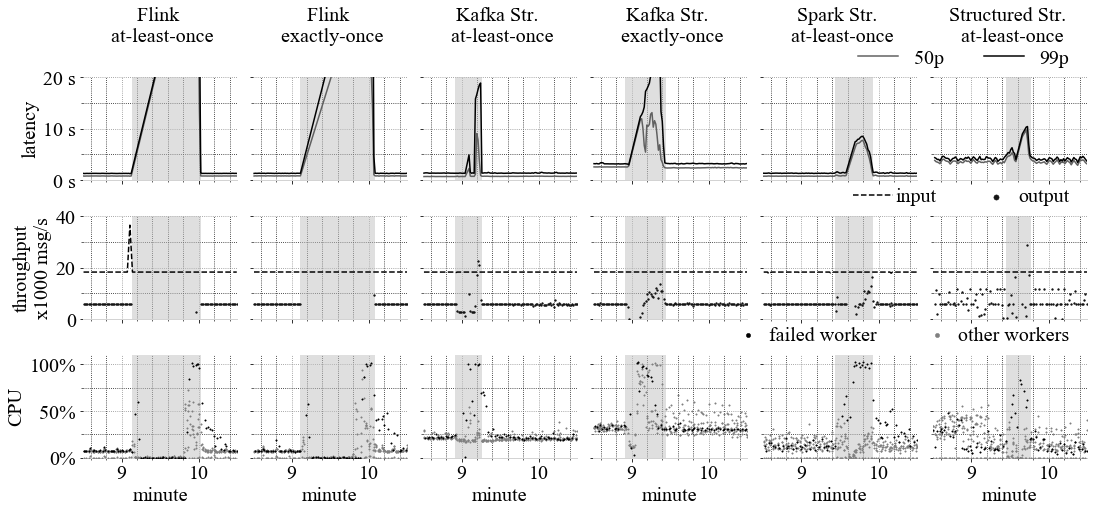

In [24]:
# frameworks=["FLINK", "KAFKASTREAMS", "SPARK", "STRUCTUREDSTREAMING"]
frameworksPrintable2 = {
    "SPARK_EO": "Spark Str. \n exactly-once", 
    "STRUCTUREDSTREAMING_EO":"Structured Str. \n exactly-once", 
    "FLINK_EO": "Flink \n exactly-once", 
    "KAFKASTREAMS_EO": "Kafka Str. \n exactly-once",
    "SPARK_ALO": "Spark Str. \n at-least-once", 
    "STRUCTUREDSTREAMING_ALO":"Structured Str. \n at-least-once", 
    "FLINK_ALO": "Flink \n at-least-once", 
    "KAFKASTREAMS_ALO": "Kafka Str. \n at-least-once"     
}
f, ax = plt.subplots(3, len(frameworks),figsize=(18, 7), sharey='row', sharex='col')
pad = 5


for j, framework in enumerate(frameworks):
    generateWorkerFailureChart(j, containersPandas=containersPandas, \
                           latencyPandas=stageLatencyPandasShortSample[framework], \
                           throughputPandas=stageThroughputPandasShortSample[framework], \
                           inputThroughputPandas=stageInputThroughputPandasShortSample[framework], \
                           cpuPandas=stageCpuPandasShortSample[framework], start=start, end=end)
    ax[0, j].annotate(frameworksPrintable2[framework], xy=(0.5, 1.3), xytext=(0, pad),
            xycoords='axes fraction', textcoords='offset points',
            size='medium', ha='center', va='baseline')

plt.subplots_adjust(wspace=0.1, hspace=0.35)

save_img_colored_and_grayscale("./figures/worker-failure/overall/phase" + str(NOTEBOOK_PHASE) + "/worker_failure_" + str(NOTEBOOK_PHASE) )
plt.show()

In [25]:
start = 0
end = 25
for j, framework in enumerate(frameworks):
    print(framework)

    throughputAroundFailure = throughputTimeseriesDataWithStartup[framework].orderBy("timeSec") \
        .filter((col("timeSec") >start) & (col("timeSec")<end))\
        .withColumn("minute", F.round(col("timeSec")+0.5))\
        .groupBy("minute").agg(sum("outputMsgCount")).orderBy("minute").show()
    

FLINK_ALO
+------+-------------------+
|minute|sum(outputMsgCount)|
+------+-------------------+
|   3.0|              73016|
|   4.0|             345600|
|   5.0|             345600|
|   6.0|             345600|
|   7.0|             345600|
|   8.0|             345600|
|   9.0|             345600|
|  10.0|             204088|
|  11.0|             498632|
|  12.0|             345600|
|  13.0|             345600|
|  14.0|             345600|
|  15.0|             345600|
|  16.0|             345600|
|  17.0|              69120|
+------+-------------------+

FLINK_EO
+------+-------------------+
|minute|sum(outputMsgCount)|
+------+-------------------+
|   3.0|              74880|
|   4.0|             345600|
|   5.0|             345600|
|   6.0|             345600|
|   7.0|             345600|
|   8.0|             345600|
|   9.0|             345600|
|  10.0|              40320|
|  11.0|             650880|
|  12.0|             345600|
|  13.0|             345600|
|  14.0|             34

In [26]:
for framework in frameworks:
#     cpuTimeseriesDataWithStartup[framework].show()
    print(framework)
    time_of_restart = cpuTimeseriesDataWithStartup[framework]\
        .filter(col("containerName").contains("-1"))\
        .groupBy("containerTaskId")\
        .agg(F.min("timeSec").alias("timeSec"))\
        .toPandas()["timeSec"].max()
    time_of_failure = cpuTimeseriesDataWithStartup[framework]\
        .filter(col("containerName").contains("-1"))\
        .groupBy("containerTaskId")\
        .agg(F.max("timeSec").alias("timeSec"))\
        .toPandas()["timeSec"].min()

    latencyAfterFailure = latencyTimeseriesDataWithoutStartup[framework]\
        .filter((col("timeSec") > time_of_failure))\
        .withColumn("timeSinceRestart", F.round((col("timeSec")-time_of_restart)*60))\
        .orderBy("timeSec")\
        .select("framework", "time", "timeSec", "timeSinceRestart", "percentile_50_second","percentile_99_second")

    tpAFterFailure = throughputTimeseriesDataWithStartup[framework]\
        .filter((col("timeSec") > time_of_failure))\
        .withColumn("timeSinceRestart", F.round((col("timeSec")-time_of_restart)*60))\
        .orderBy("timeSec")\
        .select("framework", "timeSinceRestart", "outputMsgCount")
        
    inputTpAFterFailure = inputThroughputTimeseriesDataWithStartup[framework]\
        .filter((col("timeSec") > time_of_failure))\
        .withColumn("timeSinceRestart", F.round((col("timeSec")-time_of_restart)*60))\
        .orderBy("timeSec")\
        .select("framework", "timeSinceRestart", "inputMsgCount")

    cpuAfterFailure = cpuTimeseriesDataWithStartup[framework]\
        .filter(col("containerName").contains("-1"))\
        .filter((col("timeSec") > time_of_failure))\
        .withColumn("timeSinceRestart", F.round((col("timeSec")-time_of_restart)*60))\
        .orderBy("timeSec")\
        .select(col("framework"), col("timeSinceRestart"), col("cpuUsagePct"))
        

    display(cpuAfterFailure.join(tpAFterFailure, ["framework", "timeSinceRestart"], "outer")\
        .join(inputTpAFterFailure, ["framework", "timeSinceRestart"], "outer")\
        .join(latencyAfterFailure, ["framework", "timeSinceRestart"], "outer")\
        .withColumn("timeSinceFailure", F.round((col("timeSec")-time_of_failure)*60))\
        .orderBy("timeSinceRestart").limit(60).toPandas())

FLINK_ALO


,framework,timeSinceRestart,cpuUsagePct,outputMsgCount,inputMsgCount,time,timeSec,percentile_50_second,percentile_99_second,timeSinceFailure
0,flink,-2.0,NaN,NaN,5760,NaT,NaN,NaN,NaN,NaN
1,flink,-1.0,NaN,NaN,5760,NaT,NaN,NaN,NaN,NaN
2,flink,0.0,46.381345,NaN,5760,NaT,NaN,NaN,NaN,NaN
3,flink,1.0,NaN,NaN,5760,NaT,NaN,NaN,NaN,NaN
4,flink,2.0,59.572935,NaN,5760,NaT,NaN,NaN,NaN,NaN
5,flink,3.0,19.882733,NaN,5760,NaT,NaN,NaN,NaN,NaN
6,flink,4.0,NaN,NaN,5760,NaT,NaN,NaN,NaN,NaN
7,flink,5.0,0.255845,NaN,5760,NaT,NaN,NaN,NaN,NaN
8,flink,6.0,0.232385,NaN,5760,NaT,NaN,NaN,NaN,NaN
9,flink,7.0,NaN,NaN,5760,NaT,NaN,NaN,NaN,NaN


FLINK_EO


,framework,timeSinceRestart,cpuUsagePct,outputMsgCount,inputMsgCount,time,timeSec,percentile_50_second,percentile_99_second,timeSinceFailure
0,flink,-4.0,NaN,5760.0,5760,2020-09-20 12:06:40,9.115200,837.0,1343.0,0.0
1,flink,-3.0,NaN,NaN,5760,NaT,NaN,NaN,NaN,NaN
2,flink,-2.0,NaN,NaN,5760,NaT,NaN,NaN,NaN,NaN
3,flink,-1.0,NaN,NaN,5760,NaT,NaN,NaN,NaN,NaN
4,flink,0.0,45.473519,NaN,5760,NaT,NaN,NaN,NaN,NaN
5,flink,1.0,NaN,NaN,5760,NaT,NaN,NaN,NaN,NaN
6,flink,2.0,57.316327,NaN,5760,NaT,NaN,NaN,NaN,NaN
7,flink,3.0,21.973424,NaN,5760,NaT,NaN,NaN,NaN,NaN
8,flink,4.0,NaN,NaN,5760,NaT,NaN,NaN,NaN,NaN
9,flink,5.0,0.276944,NaN,5760,NaT,NaN,NaN,NaN,NaN


KAFKASTREAMS_ALO


,framework,timeSinceRestart,cpuUsagePct,outputMsgCount,inputMsgCount,time,timeSec,percentile_50_second,percentile_99_second,timeSinceFailure
0,kafka,-6.0,NaN,5676.0,5760,2020-09-19 07:05:43,8.913583,700.0,1340.0,0.0
1,kafka,-5.0,NaN,5747.0,5714,2020-09-19 07:05:44,8.930250,716.0,1350.0,1.0
2,kafka,-4.0,NaN,3027.0,5760,2020-09-19 07:05:45,8.946917,776.0,1341.0,2.0
3,kafka,-3.0,NaN,2660.0,5760,2020-09-19 07:05:46,8.963583,678.0,1346.0,3.0
4,kafka,-2.0,NaN,2588.0,5760,2020-09-19 07:05:47,8.980250,705.0,1390.0,4.0
5,kafka,-1.0,NaN,2607.0,5760,2020-09-19 07:05:48,8.996917,713.0,1351.0,5.0
6,kafka,0.0,48.315147,2610.0,5760,2020-09-19 07:05:49,9.013583,711.0,1322.0,6.0
7,kafka,1.0,NaN,2622.0,5760,2020-09-19 07:05:50,9.030250,703.0,1350.0,7.0
8,kafka,2.0,0.560337,1094.0,5760,2020-09-19 07:05:51,9.046917,704.0,1326.0,8.0
9,kafka,3.0,40.787643,NaN,5760,NaT,NaN,NaN,NaN,NaN


KAFKASTREAMS_EO


,framework,timeSinceRestart,cpuUsagePct,outputMsgCount,inputMsgCount,time,timeSec,percentile_50_second,percentile_99_second,timeSinceFailure
0,kafka,-4.0,NaN,5891.0,5760,2020-09-20 11:33:41,8.914867,2568.0,3201.0,0.0
1,kafka,-3.0,NaN,5818.0,5760,2020-09-20 11:33:42,8.931533,2554.0,3160.0,1.0
2,kafka,-2.0,NaN,4561.0,5760,2020-09-20 11:33:43,8.948200,2558.0,3131.0,2.0
3,kafka,-1.0,NaN,53.0,5760,2020-09-20 11:33:44,8.964867,2780.0,3003.0,3.0
4,kafka,0.0,46.663201,NaN,5760,NaT,NaN,NaN,NaN,NaN
5,kafka,1.0,10.441301,NaN,5760,NaT,NaN,NaN,NaN,NaN
6,kafka,2.0,NaN,NaN,5760,NaT,NaN,NaN,NaN,NaN
7,kafka,3.0,3.039858,NaN,5760,NaT,NaN,NaN,NaN,NaN
8,kafka,4.0,NaN,NaN,5760,NaT,NaN,NaN,NaN,NaN
9,kafka,5.0,100.929439,NaN,5760,NaT,NaN,NaN,NaN,NaN


SPARK_ALO


,framework,timeSinceRestart,cpuUsagePct,outputMsgCount,inputMsgCount,time,timeSec,percentile_50_second,percentile_99_second,timeSinceFailure
0,spark,-6.0,NaN,5760.0,5760,2020-09-18 21:07:21,9.427617,769.0,1345.0,0.0
1,spark,-5.0,NaN,2960.0,5760,2020-09-18 21:07:22,9.444283,973.0,1488.0,1.0
2,spark,-4.0,NaN,8351.0,5760,2020-09-18 21:07:23,9.460950,948.0,1633.0,2.0
3,spark,-3.0,NaN,5969.0,5760,2020-09-18 21:07:24,9.477617,849.0,1503.0,3.0
4,spark,-2.0,NaN,5760.0,5760,2020-09-18 21:07:25,9.494283,820.0,1375.0,4.0
5,spark,-1.0,NaN,5760.0,5760,2020-09-18 21:07:26,9.510950,793.0,1363.0,5.0
6,spark,0.0,44.216940,5760.0,5760,2020-09-18 21:07:27,9.527617,869.0,1478.0,6.0
7,spark,1.0,57.651234,5760.0,5760,2020-09-18 21:07:28,9.544283,878.0,1488.0,7.0
8,spark,2.0,NaN,5760.0,5760,2020-09-18 21:07:29,9.560950,828.0,1383.0,8.0
9,spark,3.0,65.824687,5760.0,5760,2020-09-18 21:07:30,9.577617,903.0,1492.0,9.0


STRUCTUREDSTREAMING_ALO


,framework,timeSinceRestart,cpuUsagePct,outputMsgCount,inputMsgCount,time,timeSec,percentile_50_second,percentile_99_second,timeSinceFailure
0,structuredstreaming,-4.0,NaN,NaN,5760,NaT,NaN,NaN,NaN,NaN
1,structuredstreaming,-3.0,NaN,448.0,5760,2020-09-18 21:38:00,9.458400,4430.0,4996.0,1.0
2,structuredstreaming,-2.0,NaN,5312.0,5760,2020-09-18 21:38:01,9.475067,4669.0,5372.0,2.0
3,structuredstreaming,-1.0,NaN,5760.0,5760,2020-09-18 21:38:02,9.491733,4719.0,5261.0,3.0
4,structuredstreaming,0.0,43.975392,9244.0,5760,2020-09-18 21:38:03,9.508400,4900.0,5932.0,4.0
5,structuredstreaming,1.0,57.138944,2276.0,5760,2020-09-18 21:38:04,9.525067,5309.0,6302.0,5.0
6,structuredstreaming,2.0,66.873252,5760.0,5760,2020-09-18 21:38:05,9.541733,4912.0,5465.0,6.0
7,structuredstreaming,3.0,48.106995,16453.0,5760,2020-09-18 21:38:06,9.558400,3854.0,5157.0,7.0
8,structuredstreaming,4.0,NaN,827.0,5760,2020-09-18 21:38:07,9.575067,3599.0,4002.0,8.0
9,structuredstreaming,5.0,33.248234,NaN,5760,NaT,NaN,NaN,NaN,NaN


In [27]:
for framework in frameworks:
    print(framework)
    print("-----------------------------")
    print("CPU BEFORE")
    print(cpuTimeseriesDataWithStartup[framework]\
        .filter(((col("timeSec") < time_of_restart-2)))\
        .stat.approxQuantile("cpuUsagePct", [0.1,0.5,0.9], 0))
        
    print("CPU AFTER")
    print(cpuTimeseriesDataWithStartup[framework]\
        .filter((col("timeSec") > time_of_restart+2))\
        .stat.approxQuantile("cpuUsagePct", [0.1,0.5,0.9], 0))
    
        
    print("...................")
    print("Latency BEFORE")
    print(latencyTimeseriesDataWithoutStartup[framework]\
        .filter(((col("timeSec") < time_of_restart-2)))\
        .select(col("percentile_50_second").cast("double"))\
        .stat.approxQuantile("percentile_50_second", [0.0,0.5,1.0], 0))
        
    print("Latency AFTER")
    print(latencyTimeseriesDataWithoutStartup[framework]\
        .filter((col("timeSec") > time_of_restart+2))\
        .stat.approxQuantile("percentile_50_second", [0.0,0.5,1.0], 0))
    print("\n")

FLINK_ALO
-----------------------------
CPU BEFORE
[0.18586693331599236, 7.26107582449913, 10.56477427482605]
CPU AFTER
[0.14493587659671903, 7.02231377363205, 8.575864881277084]
...................
Latency BEFORE
[752.0, 797.0, 851.0]
Latency AFTER
[762.0, 799.0, 825.0]


FLINK_EO
-----------------------------
CPU BEFORE
[0.1970410579815507, 7.398034632205963, 11.98154091835022]
CPU AFTER
[0.19419238669797778, 7.120272517204285, 9.267275780439377]
...................
Latency BEFORE
[773.0, 827.0, 861.0]
Latency AFTER
[758.0, 811.0, 838.0]


KAFKASTREAMS_ALO
-----------------------------
CPU BEFORE
[19.95037943124771, 21.517854928970337, 25.54289996623993]
CPU AFTER
[19.222882390022278, 20.53268998861313, 23.35578054189682]
...................
Latency BEFORE
[686.0, 717.0, 782.0]
Latency AFTER
[710.0, 741.0, 1168.0]


KAFKASTREAMS_EO
-----------------------------
CPU BEFORE
[29.903995990753174, 33.71347188949585, 38.436391949653625]
CPU AFTER
[27.025070786476135, 30.875319242477417, 46